# IBOVESPA

## Lendo arquivo de dados Ibovespa

In [1]:
import pandas as pd

def ler_csv(caminho_arquivo):
    return pd.read_csv(caminho_arquivo, sep=',',usecols=[0,1], decimal=',', header=0)

df = ler_csv('dados/ibovespa.csv')

## Pré - tratamento dos dados

In [2]:
def df_tratamento_dados(df):
    df = df.rename(columns={'Data':'data','Último': 'value'})
    df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')
    df = df.sort_values(by='data')
    # Completando dados
    # Crie um novo DataFrame com um intervalo completo de datas
    data_inicio = df['data'].min()  # Data de início
    data_fim = df['data'].max()  
    datas_completas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
    # Crie um novo DataFrame com o intervalo completo de datas
    df_completo = pd.DataFrame(datas_completas, columns=['data'])# Faça um merge com o dataframe original

    df = df_completo.merge(df, on='data', how='left')
    df = df.sort_values(by='data')

    
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df.index = pd.to_datetime(df['data'])
    # Interpolação linear
    df['value'] = df['value'].interpolate(method='linear')
    df.set_index('data', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    df = df.asfreq('D')
    return df

In [3]:
df_arima = df_tratamento_dados(df)

In [5]:
df_arima.describe()

,value
count,5020.000000
mean,76.935118
std,24.621245
min,38.031000
25%,55.935429
50%,67.401929
75%,101.955893
max,130.126000


In [17]:
# Calcule a média e o desvio padrão
media_value = df_arima['value'].mean()
desvio_padrao_value = df_arima['value'].std()

# Calcule o coeficiente de variação
cv_value = (desvio_padrao_value / media_value) * 100
cv_value

32.00260895509708

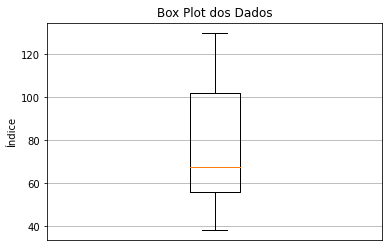

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Dados de exemplo (substitua pelos seus dados)
dados = np.random.normal(0, 1, 100)  # Dados aleatórios com distribuição normal

# Crie o box plot
plt.boxplot(df_arima)
plt.title("Box Plot dos Dados")
plt.xticks([])
plt.ylabel("Índice")
plt.grid(True)  # Adicione linhas de grade para melhor visualização

# Exiba o gráfico
plt.show()

In [4]:
plt.figure(figsize=(20, 6))
plt.plot(df_arima["value"])
plt.xlabel("data")
plt.ylabel("Adj Closing Price ($)")
plt.title("Apple Stock Prices Over Time")
plt.show()

NameError: name 'plt' is not defined

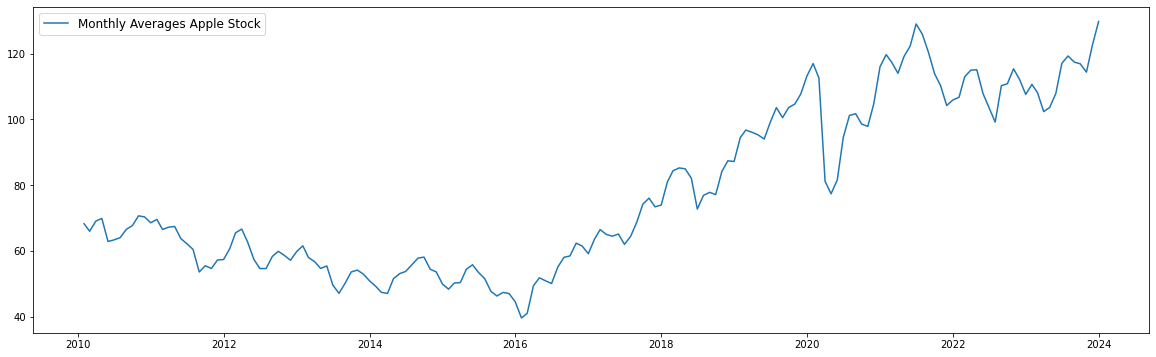

In [172]:
monthly_mean = df_arima['value'].resample('M').mean()
df_arima = monthly_mean.to_frame()
##Monthly Stock Price 
fig = plt.figure(figsize=(20,6))
plt.plot(df_arima['value'],label='Monthly Averages Apple Stock')
plt.legend(prop={'size': 12})
plt.show()

Observations: 69
Training Observations: 36
Testing Observations: 33
train e test 1
Observations: 102
Training Observations: 69
Testing Observations: 33
train e test 2
Observations: 135
Training Observations: 102
Testing Observations: 33
train e test 3


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Observations: 168
Training Observations: 135
Testing Observations: 33
train e test 4


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<Figure size 432x288 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

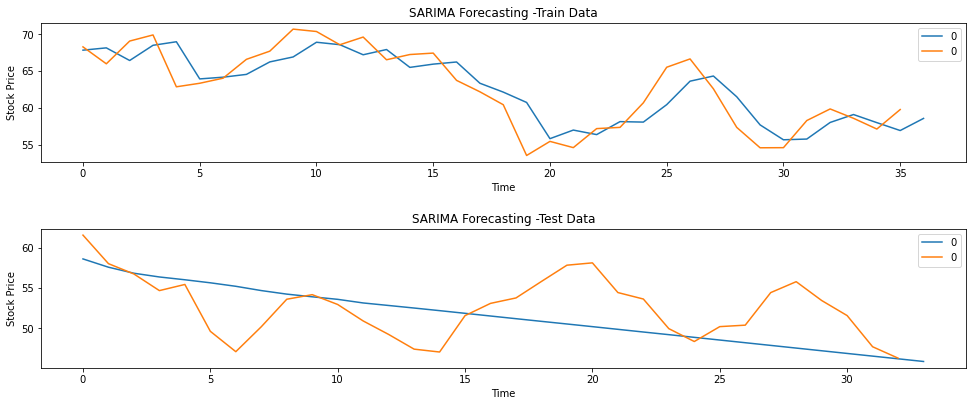

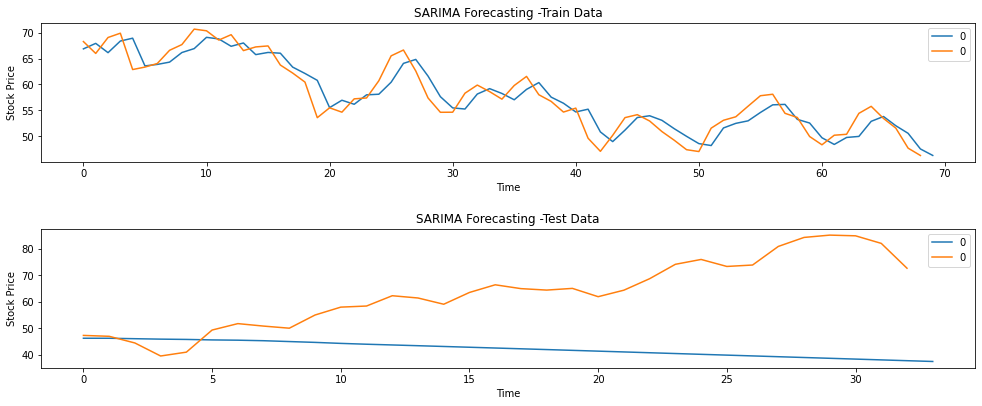

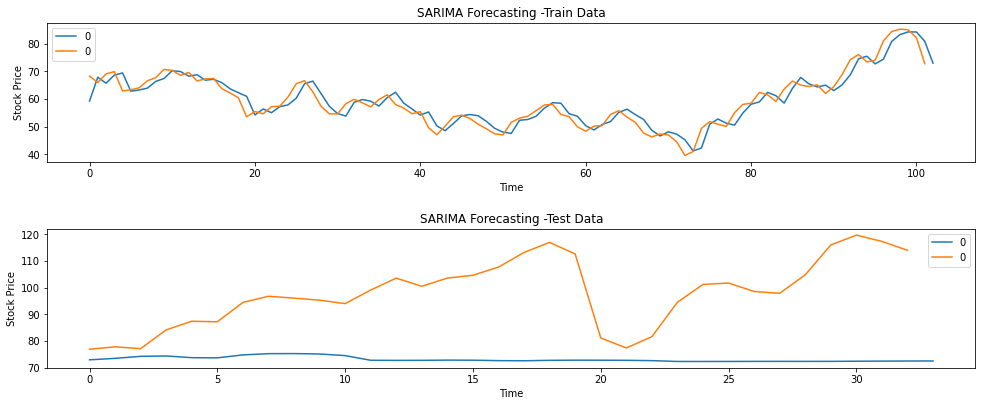

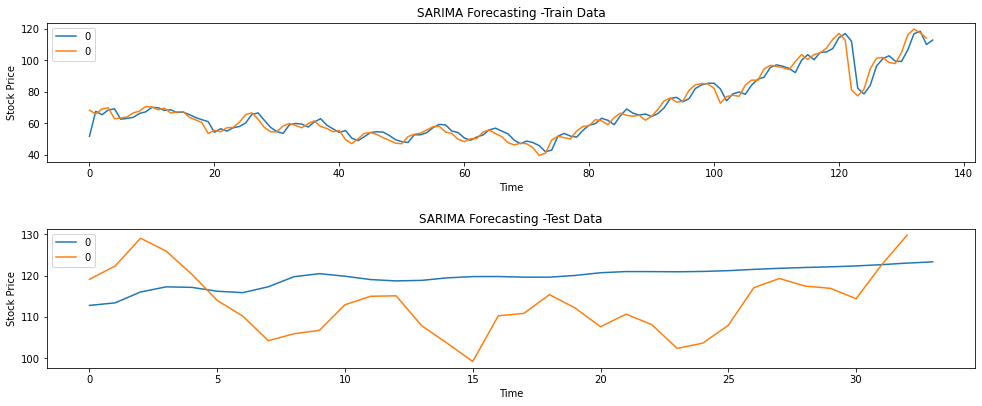

In [125]:
import statsmodels.api as sm
def backtest_model(train,test):
    model = sm.tsa.SARIMAX(train,order=(1,0,0),seasonal_order=(1,0,0,12),  trend ='ct')
    results=model.fit()

    forecasts_train = results.predict(start=0,end=len(train))
    forecasts_test = results.predict(start=len(train),end=len(train)+len(test))


    fig,(ax1,ax2) = plt.subplots(2,figsize=(14,6))

    train = pd.DataFrame(train)
    test = pd.DataFrame(test)

    forecasts_train = pd.DataFrame(forecasts_train)
    forecasts_test = pd.DataFrame(forecasts_test)

    forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
    train.plot(label='Actual',ax=ax1)
    ax1.set_ylabel('Stock Price')
    ax1.set_xlabel('Time')

    forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
    test.plot(label='Actual',ax=ax2)
    ax2.set_ylabel('Stock Price')
    ax2.set_xlabel('Time')

    ax1.legend()
    ax2.legend()
    plt.tight_layout(pad=2)
modelling_series = monthly_data['value']
## Using TimeSeriesSplit from sklearn library
from sklearn.model_selection import TimeSeriesSplit
time_series_splits = TimeSeriesSplit(n_splits=4)
X = modelling_series.values
plt.figure(1)
fig = plt.figure(figsize=(24, 10))

index = 1
count = 0
for train_index, test_index in time_series_splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))

    #plt.subplot(360 + index)
    #plt.plot(train)
    #plt.plot([None for i in train] + [x for x in test])
    # pyplot.title(''.format())
    count += 1
    print(f'train e test {count}')
    backtest_model(train,test)
    index += 1
plt.show()

# Separando os dados de treino e de teste

In [179]:
def split(df_arima, perc):
    train = df_arima[:int(len(df_arima)*perc)]
    test = df_arima[len(train):]
    print(len(train))
    print(len(test))
    return train, test

arima_train, arima_test = split(df_arima, 0.8)

4085
1022


## Decompondo a série

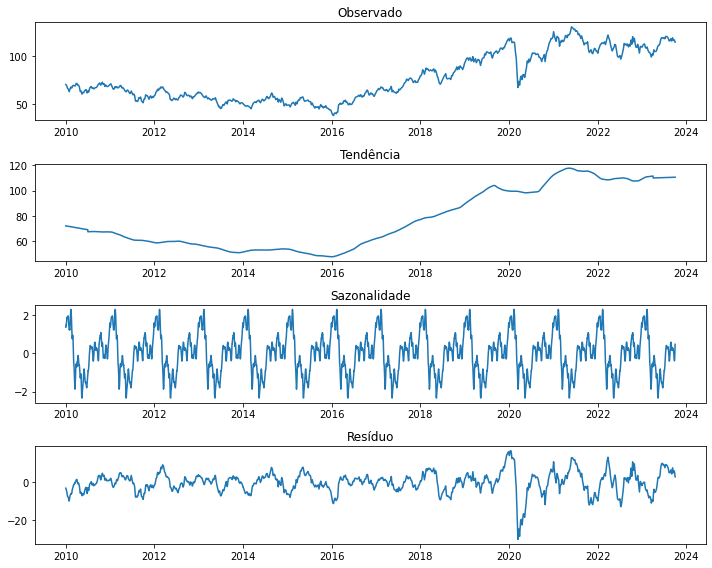

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(df_arima, model='additive',period=365,extrapolate_trend='freq')
# Plota o resultado da decomposição
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,8))

# Você pode alterar os rótulos aqui
ax1.set_title('Observado')
ax1.plot(result.observed)

ax2.set_title('Tendência')
ax2.plot(result.trend)

ax3.set_title('Sazonalidade')
ax3.plot(result.seasonal)

ax4.set_title('Resíduo')
ax4.plot(result.resid)

plt.tight_layout()
plt.show()

## Verificando estacionariedade da série e da componente sasonal

In [181]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(df):
    dftest = adfuller(df)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [182]:
# Componente sasonal
seasonal = result.seasonal
check_stationarity(seasonal)

The series is stationary


In [183]:
# série temporal
check_stationarity(arima_train['value'])

The series is NOT stationary


## Plotando os gráficos de ACF e PCF da série

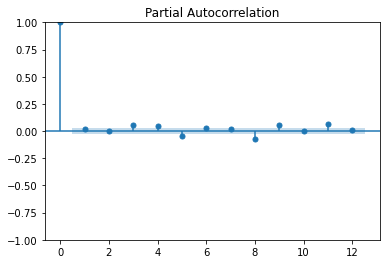

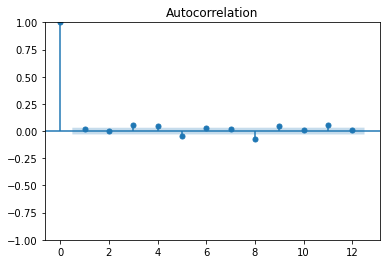

In [184]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(arima_train.diff().dropna(), lags =12)
plt.show()
plot_acf(arima_train.diff().dropna(), lags =12)
plt.show()

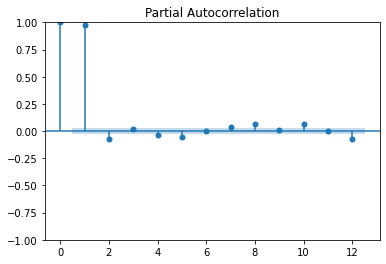

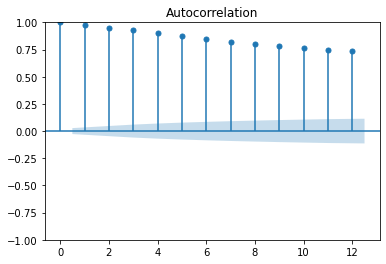

In [187]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal.dropna(), lags =12)
plt.show()
plot_acf(seasonal.dropna(), lags =12)
plt.show()

#### Analisando os gráficos pode ser visto que uma possível configuração pode ser pdq = 1,1,1 e PDQ = 0,0,1

In [188]:
ACF_PACF_config = [(1,1,1),(2,0,0, 12),'n']

In [138]:
ACF_PACF_config_arima = [(2,1,1)]

# Parâmetros com auto arima

In [189]:
from pmdarima import auto_arima

# Suponha que 'data' seja a sua série temporal
auto_arima_config = auto_arima(df_arima, seasonal=True, m=12)  # m é o período da sazonalidade

In [141]:
# Suponha que 'data' seja a sua série temporal
auto_arima_config_arima = auto_arima(df_arima, seasonal=False)  # m é o período da sazonalidade

In [190]:
# Obter os parâmetros 'order' e 'seasonal_order'
order = auto_arima_config.order
seasonal_order = auto_arima_config.seasonal_order
auto_arima_config = [order,seasonal_order,'n']
auto_arima_config

[(1, 1, 1), (0, 0, 0, 12), 'n']

In [143]:
# Obter os parâmetros 'order' e 'seasonal_order'
order = auto_arima_config_arima.order
auto_arima_config_arima = [order]
auto_arima_config_arima

[(2, 1, 2)]

##### O Auto Arima retornou como parãmetros pdq = 0,1,0 e PDQ = 0,0,0

# Parâmetros com grid search

## Carregando funções

In [191]:
import itertools
def sarima_parameter_search(inicio,search_range, seasonal = [12]):
    """
    Get all of the parameter combinations for a SARIMA model.
    """
    p = q = d = range(inicio, search_range)
    trend = ['n','c','t','ct']
    pdq = list(itertools.product(p, d, q))
    pdq_combinations = [(x[0], x[1], x[2], x[3], x[4]) for x in list(itertools.product(p, d, q, seasonal, trend))]
    return pdq, pdq_combinations

### EXECUTE IN MAIN FUNCTION ###
order_combos, seasonal_order_combos = sarima_parameter_search(inicio=0, search_range = 2)

In [192]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
def seasonal_arima_model(time_series=None, order=None, seasonal_order=None, trend=None, steps=None, modo=None):
    """
    Generate a seasonal ARIMA model using a set of hyperparameters. Returns the model fit, and the 
    associated model AIC and BIC values.
    """ 
    try:
        if modo == "SARIMA":
            model = SARIMAX(time_series, 
                                       order=order, 
                                       seasonal_order=seasonal_order, 
                                       trend = trend,
                                       enforce_stationarity=False, 
                                       enforce_invertibility=False)
            model_fit = model.fit()
            prediction = model_fit.forecast(steps=steps)
            # Calcule o MAE, MAPE e RMSE
            rmse = np.sqrt(mean_squared_error(arima_test, prediction))
            mae = mean_absolute_error(arima_test, prediction)
            mape = mean_absolute_percentage_error(arima_test, prediction)
            return rmse,mae,mape, model_fit, prediction
        elif modo == "ARIMA":         
            model = ARIMA(time_series, order=order)
            model_fit = model.fit()
            prediction = model_fit.forecast(steps=steps)
            rmse = np.sqrt(mean_squared_error(arima_test, prediction))
            
            return rmse, model_fit, prediction
    except:
        print("Could not fit with the designated model parameters")
        return None, None, None


def seasonal_arima_model_arima(time_series=None, order=None, steps=None):
    """
    Generate a seasonal ARIMA model using a set of hyperparameters. Returns the model fit, and the 
    associated model AIC and BIC values.
    """ 
    try:
        model = ARIMA(time_series, order=order)
        model_fit = model.fit()
        prediction = model_fit.forecast(steps=steps)
        rmse = np.sqrt(mean_squared_error(arima_test, prediction))

        return rmse, model_fit, prediction
    except:
        print("Could not fit with the designated model parameters")
        return None, None, None

def grid_search(order_combos,seasonal_order_combos, df, steps, modo):
    lowest_rmse = 100000000000
    lowest_mae = 100000000000
    lowest_mape = 100000000000
    
    if modo == "ARIMA":
        for order_combo in order_combos:
            #Generate the ARIMA model
            rmse,model_fit, prediction  = seasonal_arima_model(time_series = df, 
                                                        order = order_combo, 
                                                        steps=steps,
                                                        modo=modo)
            print("order-- ", order_combo, ", lowest_rmse--",rmse)
            if (rmse < lowest_rmse):
                lowest_rmse = rmse
                best_model = model_fit
                best_order = order_combo
        melhor_conf = best_order
        return lowest_rmse,best_model,melhor_conf
                
    elif modo == "SARIMA":
        #Generate  model for each of hyperparameter combination in a loop
        for order_combo in order_combos:
            for seasonal_order_combo in seasonal_order_combos:
                #Convert the combination to list format
                seasonal_order_combo = list(seasonal_order_combo)
                #Generate the SARIMA model
                rmse,mae,mape,model_fit, prediction  = seasonal_arima_model(time_series = df, 
                                                            order = order_combo, 
                                                            seasonal_order = seasonal_order_combo[0:4],
                                                            trend = seasonal_order_combo[-1],
                                                            steps=steps,
                                                            modo=modo)
                print("order-- ", order_combo, ", seasonal order-- ", seasonal_order_combo, ", rmse--",rmse,", mae--",mae,", mape--",mape)
                if (rmse < lowest_rmse) or (mae < lowest_mae) or (mape < lowest_mape):
                    lowest_rmse = rmse
                    lowest_mae = mae
                    lowest_mape = mape
                    best_model = model_fit
                    best_order = order_combo
                    best_seasonal_order = seasonal_order_combo

                #print("Best model paramaters: order-- ", best_order, ", seasonal order-- ", best_seasonal_order, ", lowest_rmse--",lowest_rmse)
        melhor_conf = [best_order,tuple(best_seasonal_order[0:4]),best_seasonal_order[-1]]
        return lowest_rmse,lowest_mae,lowest_mape,best_model,melhor_conf

In [193]:
rmse,mae,mape,model, grid_search_melhor_conf, = grid_search(order_combos,seasonal_order_combos, arima_train, len(arima_test), "SARIMA")
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}")

order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 113.54423870279449 , mae-- 113.27533512720156 , mape-- 1.0
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 45.20418000886114 , mae-- 44.52443481793082 , mape-- 0.3901933513169117
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 19.26128235728859 , mae-- 17.264346708468324 , mape-- 0.15638272100457082
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 18.675961536007048 , mae-- 16.573312004438574 , mape-- 0.14217350939108886
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 113.00053407320674 , mae-- 112.53645211315133 , mape-- 0.993571888349773
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 44.98494427232239 , mae-- 44.24252458335657 , mape-- 0.38773845171957905
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 19.278916187419654 , mae-- 17.29556828058773 , mape-- 0.15666120643751377


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 18.44537557005843 , mae-- 16.322208167527474 , mape-- 0.1399706783201719
order--  (0, 0, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 8.033031284950736 , mae-- 6.460129908675799 , mape-- 0.05666657395221294
order--  (0, 0, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 9.684222595232482 , mae-- 8.147938492218788 , mape-- 0.07380788813968456
order--  (0, 0, 0) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 21.505089689347436 , mae-- 19.22624362072146 , mape-- 0.17339015394089427


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 29.80220412315525 , mae-- 26.309858812227958 , mape-- 0.236514994193127
order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 8.217540969187079 , mae-- 6.593922302382297 , mape-- 0.05768927657724213
order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 9.917960695222005 , mae-- 8.339137991792937 , mape-- 0.07547486032124011
order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 21.147441968349256 , mae-- 18.880779030455788 , mape-- 0.17021447109951285
order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 29.351219712448618 , mae-- 25.90652986777663 , mape-- 0.23282270997039
order--  (0, 0, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 10.481341898556826 , mae-- 8.948052212514279 , mape-- 0.08118857226621685
order--  (0, 0, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 9.4654878615303 , mae-- 7.511459902178665 , mape-- 0.06424724804711035
order--  (0, 0, 0) ,

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 20.964263161389557 , mae-- 18.753161140064496 , mape-- 0.16921016212420062
order--  (0, 0, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 28.53310818040594 , mae-- 25.23632100569351 , mape-- 0.22698469914254144
order--  (0, 0, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 7.966332910681226 , mae-- 6.420167145290355 , mape-- 0.056459700963375895
order--  (0, 0, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 10.147152453228696 , mae-- 8.637688808904537 , mape-- 0.07840934680949747
order--  (0, 0, 1) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 21.30850201750876 , mae-- 19.059065081085173 , mape-- 0.17201732928286653
order--  (0, 0, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 28.574781837953456 , mae-- 25.272260718882272 , mape-- 0.2273022729359779
order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 9.514811635324271 , mae-- 7.980952410413923 , mape-- 0.07228797180549566
order--  (0,

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 24.79797691359654 , mae-- 22.194484950623355 , mape-- 0.20018704934077008


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 38.06195584220948 , mae-- 37.221571422056435 , mape-- 0.325487460106016
order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 9.805793806468346 , mae-- 8.285552243248189 , mape-- 0.07514128375545764


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 18.9074671358566 , mae-- 16.22143823030809 , mape-- 0.13985213243009129


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 20.575133031690395 , mae-- 18.497339117635562 , mape-- 0.1671439972442652


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 26.798400897630103 , mae-- 25.517578714785916 , mape-- 0.22160305955971504
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 7.966171286522392 , mae-- 6.419888029859271 , mape-- 0.056456138187328794
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 10.063868056195446 , mae-- 8.553535269363644 , mape-- 0.07763157387507404
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 20.25330441043997 , mae-- 18.10338844379486 , mape-- 0.16330714338323266
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 28.951043122942124 , mae-- 25.56699978470188 , mape-- 0.22981772120360353
order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 7.96560803944737 , mae-- 6.419793640411783 , mape-- 0.056459147567644315
order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 10.17529313370995 , mae-- 8.666100748010143 , mape-- 0.07867313437668436
order--  (0, 

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 24.821670254934013 , mae-- 22.104848955760406 , mape-- 0.19957611586142604


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 33.50831026778835 , mae-- 29.471820759750884 , mape-- 0.26518431433979667
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 8.004299336332355 , mae-- 6.520984803717493 , mape-- 0.05858375045376724
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 11.448131200623438 , mae-- 9.898407391286794 , mape-- 0.09042078615256542


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 24.84421894873361 , mae-- 22.124469830087115 , mape-- 0.19975599876467773


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 33.53051363593958 , mae-- 29.491245905323524 , mape-- 0.2653620375468621
order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 239.96764590880863 , mae-- 207.86183350483208 , mape-- 1.8522863081129326
order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 267.25145385198675 , mae-- 228.92542450874828 , mape-- 2.0378462880533874
order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 311.69040776978846 , mae-- 262.731155667597 , mape-- 2.335371632383127
order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 326.7374205928639 , mae-- 274.0634006729832 , mape-- 2.4350442718852743
order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 11.621235219157885 , mae-- 10.06634006866488 , mape-- 0.0919492125639736
order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 32.99193237671149 , mae-- 29.03773599586914 , mape-- 0.2613232212047832


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 35.637490825775025 , mae-- 26.528059452201145 , mape-- 0.22967172555037949


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 19.605894398720952 , mae-- 14.87223753362989 , mape-- 0.1277597232731877
order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 8.004360159827819 , mae-- 6.521036173910601 , mape-- 0.058584338173343985
order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 11.466811411470207 , mae-- 9.916512568046798 , mape-- 0.0905858467974365


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 24.882248155835192 , mae-- 22.1574032344078 , mape-- 0.20005237767488623
order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 33.6509590944981 , mae-- 29.593001939474643 , mape-- 0.266270917099859
order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 8.0021204247225 , mae-- 6.519138735121638 , mape-- 0.058562615000659256
order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 11.595456341489081 , mae-- 10.041808488482651 , mape-- 0.09172301477852209


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 24.233826531724226 , mae-- 21.59617666023387 , mape-- 0.1950418195875496
order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 34.06408816849081 , mae-- 29.935054135799316 , mape-- 0.26930509493006355
order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 7.90433420179204 , mae-- 6.35085263367217 , mape-- 0.05578810917812168
order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 13.877603664974869 , mae-- 12.100977148928775 , mape-- 0.10882635320940097
order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 20.442817084527693 , mae-- 15.155823054695276 , mape-- 0.13006957770204125


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 11.382199027666841 , mae-- 8.621357761994116 , mape-- 0.07373230983456369
order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 11.618802542365502 , mae-- 10.063986539630692 , mape-- 0.09192779671277777
order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 32.77924187876132 , mae-- 28.858382002078496 , mape-- 0.259724853560831


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 43.872273342520394 , mae-- 33.80650473484696 , mape-- 0.2941413258373549


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 28.36286177911867 , mae-- 22.19046413086486 , mape-- 0.19201434491414984
order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 8.003230267907657 , mae-- 6.520171847699913 , mape-- 0.05857419923657457
order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 11.280932271488886 , mae-- 9.737397287193142 , mape-- 0.08895026683324961


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 24.5323164874355 , mae-- 21.85486708113902 , mape-- 0.19735269276045292


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 33.23250448648752 , mae-- 29.239464826540683 , mape-- 0.26311834130243167
order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 8.011629575739168 , mae-- 6.527314577955786 , mape-- 0.058655666681603644
order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 11.455963982995335 , mae-- 9.905256883997493 , mape-- 0.09048833427481906


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 24.55506664181312 , mae-- 21.874675343746233 , mape-- 0.19753429373823392


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 33.25492196515694 , mae-- 29.25907788470412 , mape-- 0.26329778387415315
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 237.9804252310776 , mae-- 206.1349612681471 , mape-- 1.8369372585266621
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 266.62445409283396 , mae-- 228.245100934976 , mape-- 2.0317168849135507
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 308.3208003986537 , mae-- 259.9565824013923 , mape-- 2.3108011273434976
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 327.93165390143713 , mae-- 274.72396065577277 , mape-- 2.440688880728746
order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 11.388967251922894 , mae-- 9.840774582685414 , mape-- 0.08990017744587901
order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 33.18150907997618 , mae-- 29.198600388520994 , mape-- 0.2627631233964448


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 35.69635682521985 , mae-- 26.63748670347374 , mape-- 0.2306536797046469


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 15.226657624802439 , mae-- 11.751657471900959 , mape-- 0.10068213608099999
order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 8.011709388544634 , mae-- 6.527383590353317 , mape-- 0.058656448724154285
order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 11.490076745232109 , mae-- 9.938294004430404 , mape-- 0.09078949061290818


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 24.758989379822676 , mae-- 22.051123063056554 , mape-- 0.19911109869797572


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 33.54584158245904 , mae-- 29.505143411914027 , mape-- 0.2654937753078271
order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 8.006695843485826 , mae-- 6.523115738234828 , mape-- 0.058607810475545974
order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 11.633102551852966 , mae-- 10.077349942383579 , mape-- 0.09205190275502516
order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 24.052601887434804 , mae-- 21.439309035600477 , mape-- 0.19364918844998888


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 33.89212933507261 , mae-- 29.790743511398084 , mape-- 0.26802446120732987
order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 7.900179486062586 , mae-- 6.34853948839742 , mape-- 0.05578450157663781
order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 13.781368736745636 , mae-- 12.018063933681908 , mape-- 0.10809900393914908


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 21.419687243914975 , mae-- 15.939187692174505 , mape-- 0.13685363555607002


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 9.91580142902702 , mae-- 7.684433168864879 , mape-- 0.06588602164716799
order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 11.415374810895303 , mae-- 9.866135767736171 , mape-- 0.0901317114042664
order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 33.18018258755645 , mae-- 29.197489303829986 , mape-- 0.2627532649682249


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 44.02030302961863 , mae-- 34.0020442402777 , mape-- 0.2958988217398989


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 24.070606028239645 , mae-- 19.01835343480032 , mape-- 0.16417217583967914
order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 13.540240233082685 , mae-- 11.921783694739197 , mape-- 0.10868454348231885
order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 8.063957889884467 , mae-- 6.567301950757261 , mape-- 0.05909031522486065


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 23.426335164852475 , mae-- 20.92532010872457 , mape-- 0.1891568018409451


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 11.920645950147847 , mae-- 10.378214671175334 , mape-- 0.09458268953941021
order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 13.417132729629394 , mae-- 11.802828124091583 , mape-- 0.10762314286853467
order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 7.927308214149326 , mae-- 6.458620153261821 , mape-- 0.05787782545827549
order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 13.293035487685016 , mae-- 11.673931436173168 , mape-- 0.10650088546671344


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 10.59894730313498 , mae-- 9.067624807731667 , mape-- 0.08273327091273479
order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 8.964318594824675 , mae-- 7.341860805151042 , mape-- 0.06690468908904373
order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 13.455868802563598 , mae-- 11.727287524479 , mape-- 0.10731529003612474
order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 27.706311454360534 , mae-- 24.62104142522583 , mape-- 0.2223657593782173
order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 36.387122094052835 , mae-- 31.998671107651184 , mape-- 0.28801844338264865
order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 8.001254713426347 , mae-- 6.518009230049366 , mape-- 0.05855034150780866
order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 11.815412423102737 , mae-- 10.275928049814933 , mape-- 0.09366221192699223
order--  (1, 0,

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 38.45872849510702 , mae-- 33.93170201134155 , mape-- 0.3055035336621759
order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 13.443982227084216 , mae-- 11.828541714192292 , mape-- 0.10785422750860534
order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 7.7936632789262195 , mae-- 6.327935915904184 , mape-- 0.05623041169891751


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 14.383604751507692 , mae-- 12.424607837185311 , mape-- 0.11318181366777608
order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 7.126240945565905 , mae-- 5.5857328065665035 , mape-- 0.04943807150131772
order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 13.643032799865981 , mae-- 12.01907981903382 , mape-- 0.1095627732317226


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 7.953280585288014 , mae-- 6.479537430988965 , mape-- 0.058115421608479996


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 29.08718394264728 , mae-- 20.29602160791671 , mape-- 0.17453966055267114
order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 11.438594254135209 , mae-- 9.801545727297633 , mape-- 0.08393731131496697
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 7.8647272590476485 , mae-- 6.336760313329465 , mape-- 0.05612433567683778
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 10.85901185507887 , mae-- 9.358843600022443 , mape-- 0.08515917033971641
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 29.14621445315705 , mae-- 25.942841222945166 , mape-- 0.2344097968799273
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 39.21026232413285 , mae-- 34.532020054725244 , mape-- 0.31080250394998665
order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 8.007091701262617 , mae-- 6.522600092054339 , mape-- 0.05860138108773491
order--  (1, 0,

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 29.449410364671188 , mae-- 26.21992916834597 , mape-- 0.23691167176188044


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 39.49648000002192 , mae-- 34.80311257626542 , mape-- 0.3132423510419389
order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 13.298588758215004 , mae-- 11.689779924103167 , mape-- 0.1066056656798131
order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 7.907883901912158 , mae-- 6.442384612166244 , mape-- 0.05768827261959587


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 23.321613695902613 , mae-- 20.83346010590579 , mape-- 0.18834217568789408


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 11.5820260809231 , mae-- 10.050478626084157 , mape-- 0.09160669914150403
order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 13.304912096213853 , mae-- 11.6949118305434 , mape-- 0.10665743966150582
order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 7.817500686417817 , mae-- 6.358083462037404 , mape-- 0.05665198379744926
order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 12.897618371596373 , mae-- 11.307595460112838 , mape-- 0.10317334410609547
order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 7.780256255866896 , mae-- 6.183187591404789 , mape-- 0.05392911891726525
order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 8.895377957744266 , mae-- 7.281836348606698 , mape-- 0.06630950011106816
order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 13.333909212516645 , mae-- 11.61589904063695 , mape-- 0.10628713737453706


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 27.24518742233365 , mae-- 24.218805845764535 , mape-- 0.2187582147425094
order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 35.60744921512286 , mae-- 31.331878930010113 , mape-- 0.2820609824131671
order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 7.86210190668526 , mae-- 6.403105990226327 , mape-- 0.057224064739237
order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 11.414413364672976 , mae-- 9.886442555844745 , mape-- 0.09012216485622922


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 29.055699476147115 , mae-- 25.87078753722922 , mape-- 0.23377552903296123
order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 37.40113915138968 , mae-- 33.007262014802855 , mape-- 0.2972512984087294
order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 13.323238323453305 , mae-- 11.712277649705117 , mape-- 0.10681457520484573
order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 7.892610839163806 , mae-- 6.430053903860585 , mape-- 0.05754426361592078
order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 91.35675310659073 , mae-- 68.76100688313092 , mape-- 0.6063614815892137
order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 14.10467302432239 , mae-- 11.557511758099658 , mape-- 0.09888995326400657
order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 14.092337815450914 , mae-- 12.445141783401468 , mape-- 0.11339221927918434


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 7.836799913437992 , mae-- 6.301593384420098 , mape-- 0.05546734277729125
order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 7.204208609737165 , mae-- 5.780159682978902 , mape-- 0.05216474933820374
order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 10.552899090612355 , mae-- 8.921810027211695 , mape-- 0.07629730781684053
order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 7.866140287985257 , mae-- 6.339815215074188 , mape-- 0.05617575767310008
order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 10.871428497060412 , mae-- 9.370566572689542 , mape-- 0.08527636839153764
order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 28.675585593972446 , mae-- 25.524215251220813 , mape-- 0.23064830880311363
order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 38.295153166485484 , mae-- 33.73257728538761 , mape-- 0.3036642076537446
order--  (1, 0

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 28.967246582719515 , mae-- 25.78929260229754 , mape-- 0.23304315301944176


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 38.570838797943715 , mae-- 33.99259872425802 , mape-- 0.3060052843825521
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 8.00343923830644 , mae-- 6.520350754479273 , mape-- 0.058576241565035145
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 11.333802029295558 , mae-- 9.788286358559427 , mape-- 0.08941535723724674
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 24.882611639724622 , mae-- 22.157795381194912 , mape-- 0.20005548172432994
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 33.65037406154072 , mae-- 29.59263471210416 , mape-- 0.2662673914867503
order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 8.011824904216889 , mae-- 6.527485931421443 , mape-- 0.058657602393389484
order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 11.471910788546847 , mae-- 9.920694461410882 , mape-- 0.09062916387685391


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 24.905365342908222 , mae-- 22.177634230152194 , mape-- 0.20023731515982957
order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 33.67847755229506 , mae-- 29.617100497432983 , mape-- 0.26649006878971376
order--  (1, 1, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 238.12367156259185 , mae-- 206.25942762034154 , mape-- 1.8380435595732372
order--  (1, 1, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 265.3659108604631 , mae-- 227.29119914216682 , mape-- 2.0233233040493555
order--  (1, 1, 0) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 309.31470782103736 , mae-- 260.72355981439097 , mape-- 2.3175616850362015
order--  (1, 1, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 323.4684495321933 , mae-- 271.38356137317766 , mape-- 2.411321180905109
order--  (1, 1, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 11.383291803600498 , mae-- 9.835297668445417 , mape-- 0.08985031396778861
order--  (1, 

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 35.242418513249916 , mae-- 26.295741971890358 , mape-- 0.22764950774631174


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 20.068067813166305 , mae-- 15.236834656397619 , mape-- 0.13092144674195658
order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 8.011903785017985 , mae-- 6.527554781211234 , mape-- 0.05865838081001053
order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 11.477496257494172 , mae-- 9.926093342170299 , mape-- 0.09067843061892024
order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 24.926820817401385 , mae-- 22.19626587104782 , mape-- 0.20040610108291956
order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 33.77523640761555 , mae-- 29.698809581605893 , mape-- 0.26722014908285374
order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 8.007902591519542 , mae-- 6.524139191865986 , mape-- 0.05861949659383806
order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 11.60402976825723 , mae-- 10.049111626675135 , mape-- 0.0917957264002751


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 24.251799751429793 , mae-- 21.61201256049038 , mape-- 0.19519014436782509


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 34.17721529591132 , mae-- 30.03129953274798 , mape-- 0.2701689061136489
order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 7.900373006363068 , mae-- 6.3486492681501385 , mape-- 0.055784670290870586
order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 14.765153651033721 , mae-- 12.869370348486276 , mape-- 0.11561262492071707
order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 21.068019755744356 , mae-- 15.685146323196767 , mape-- 0.13464847462974136


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 12.303192619371883 , mae-- 9.33923382185027 , mape-- 0.07976596348280306
order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 11.427932100731303 , mae-- 9.878188872768364 , mape-- 0.09024184661254411
order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 33.146492164642574 , mae-- 29.16907539075266 , mape-- 0.2625001027659317


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 43.57897688710934 , mae-- 33.66445824379075 , mape-- 0.29292473636602456


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 28.907831712786678 , mae-- 22.66602200090585 , mape-- 0.19621857630230813
order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 8.000254215557597 , mae-- 6.517610458558278 , mape-- 0.05854496892630915
order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 11.2744564593376 , mae-- 9.731483570056266 , mape-- 0.08889417238041528
order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 17.96271800790604 , mae-- 16.0625959658689 , mape-- 0.14566213683652166


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 23.465201784875536 , mae-- 20.90570131316212 , mape-- 0.188807846552103
order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 8.008243594806752 , mae-- 6.524391847459399 , mape-- 0.05862249328279532
order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 11.43516110747235 , mae-- 9.88547400516183 , mape-- 0.0903056482964757
order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 17.98499958829897 , mae-- 16.082425215813707 , mape-- 0.14584430371708995


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 23.487862978705458 , mae-- 20.925460028958266 , mape-- 0.18898909488834686
order--  (1, 1, 1) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 236.65329899888218 , mae-- 204.98197363734081 , mape-- 1.8266890919709529
order--  (1, 1, 1) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 265.27684111762323 , mae-- 227.07669825861527 , mape-- 2.0213331349680552


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 272.97333348441833 , mae-- 232.65286307918794 , mape-- 2.070155835434378


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 302.8166339281708 , mae-- 255.22396234991066 , mape-- 2.2686815653170833
order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 11.850637135803826 , mae-- 10.27832104398999 , mape-- 0.09393359451328748
order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 21.036999715903438 , mae-- 18.79926549100695 , mape-- 0.17013615371090723


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 51.20314057172654 , mae-- 38.349985627227696 , mape-- 0.3337066488872795


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 19.13312924825451 , mae-- 14.70465432605546 , mape-- 0.1263348080205651
order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 8.00801415235188 , mae-- 6.524200084021396 , mape-- 0.05862029800144876
order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 11.464139993440318 , mae-- 9.913573208844406 , mape-- 0.09056162657663923
order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 18.11950013673286 , mae-- 16.20405255641997 , mape-- 0.1469325487343029


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 23.68097866318014 , mae-- 21.092839777415634 , mape-- 0.19048440260856622
order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 8.00384474125587 , mae-- 6.520677379109053 , mape-- 0.05858000191460296
order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 11.611425495170453 , mae-- 10.056708304360843 , mape-- 0.09186195797390553


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 19.729731845158238 , mae-- 17.64835200928315 , mape-- 0.15981871790777583
order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 26.055302892868156 , mae-- 23.13805450935841 , mape-- 0.20871895398562096
order--  (1, 1, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 7.872336003288701 , mae-- 6.333544292696122 , mape-- 0.05580206929240344
order--  (1, 1, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 15.08205018071248 , mae-- 13.1535448127254 , mape-- 0.11815895301005726
order--  (1, 1, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 32.35222276978187 , mae-- 23.973936109690676 , mape-- 0.20699386760530758


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 13.000864961989297 , mae-- 10.029703388325299 , mape-- 0.0856624999655961
order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 11.851058437027332 , mae-- 10.278726238750842 , mape-- 0.09393730170969507
order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 33.038994715712654 , mae-- 29.079626444266193 , mape-- 0.2617112999709979


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 58.946119855704424 , mae-- 45.40026748783937 , mape-- 0.3963440127298407


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 28.13665278590529 , mae-- 22.290597025826138 , mape-- 0.19304545806932505
A melhor configuração para essa série temporal é:[(1, 0, 0), (1, 0, 0, 12), 'ct']


In [147]:
rmse,model, grid_search_melhor_conf_arima = grid_search(order_combos,seasonal_order_combos, arima_train, len(arima_test), "ARIMA")
grid_search_melhor_conf_arima = [grid_search_melhor_conf_arima]
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf_arima}")

order--  (0, 0, 0) , lowest_rmse-- 45.260504768381644
order--  (0, 0, 1) , lowest_rmse-- 44.493915906143656
order--  (0, 1, 0) , lowest_rmse-- 8.435389679619895
order--  (0, 1, 1) , lowest_rmse-- 8.023623266471121


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order--  (1, 0, 0) , lowest_rmse-- 10.007404615513076
order--  (1, 0, 1) , lowest_rmse-- 16.921177232217712
order--  (1, 1, 0) , lowest_rmse-- 8.026536092175851
order--  (1, 1, 1) , lowest_rmse-- 8.074685021363031
A melhor configuração para essa série temporal é:[(0, 1, 1)]


##### O grid search retornou os parâmetros pdq = 0,1,0 e PDQ = 0,0,1

# Selecionando a melhor configuração

In [194]:
configs = [ACF_PACF_config_arima, auto_arima_config_arima,grid_search_melhor_conf_arima]
rmse = 1000000
mae = 1000000
mape = 1000000
for config in configs: 
    rmse_pred,model_fit,predicao = seasonal_arima_model_arima(arima_train, config[0],len(arima_test))
    if rmse_pred <= rmse:
        melhor_model_arima = model_fit
        #mae=mae_pred
        #mape = mape_pred 
        melhor_predicao_arima =  predicao
        rmse = rmse_pred
    print(f"RMSE da config: {config}- rmse:{rmse}")

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE da config: [(2, 1, 1)]- rmse:7.997275726242024
RMSE da config: [(2, 1, 2)]- rmse:7.997275726242024
RMSE da config: [(0, 1, 1)]- rmse:7.997275726242024


In [195]:
configs = [ACF_PACF_config, auto_arima_config,grid_search_melhor_conf]
rmse = 1000000
mae = 1000000
mape = 1000000
for config in configs: 
    rmse_pred,mae_pred,mape_pred,model_fit,predicao = seasonal_arima_model(arima_train, config[0], config[1], config[2],len(arima_test),"SARIMA")
    if rmse_pred <= rmse or mae_pred <= mae or mape_pred <= mape :
        melhor_model = model_fit
        mae=mae_pred
        mape = mape_pred 
        melhor_predicao =  predicao
        rmse = rmse_pred
    print(f"RMSE da config: {config}- rmse:{rmse}, mae:{mae}, mape:{mape}")

RMSE da config: [(1, 1, 1), (2, 0, 0, 12), 'n']- rmse:8.013769816349754, mae:6.52916254958747, mape:0.058676612291818614
RMSE da config: [(1, 1, 1), (0, 0, 0, 12), 'n']- rmse:8.000254215557597, mae:6.517610458558278, mape:0.05854496892630915
RMSE da config: [(1, 0, 0), (1, 0, 0, 12), 'ct']- rmse:7.126240945565905, mae:5.5857328065665035, mape:0.04943807150131772


In [91]:
predicao_arima = melhor_predicao.to_frame()
predicao_arima.rename(columns={'predicted_mean': 'y'}, inplace=True)
predicao_arima['ds'] = predicao_arima.index
predicao_arima = predicao_arima.reset_index(drop=True)

#### a melhor configuração é pdq = 0,1,0 e PDQ =0,0,1

In [196]:
melhor_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                 4085
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood               -5999.486
Date:                            Sun, 14 Apr 2024   AIC                          12008.972
Time:                                    09:29:54   BIC                          12040.532
Sample:                                01-04-2010   HQIC                         12020.149
                                     - 03-11-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0766      0.064      1.193      0.233      -0.049       0.202
drift       6.741e-05   1.84e-05      3.654      0.000    3.13e-05       0.000
ar.L1          0.9859      0.003    367.578      0.000       0.981       0.991
ar.S.L12       0.7570      0.010     72.664      0.000       0.737       0.777
sigma2         1.4450      0.018     81.464      0.000       1.410       1.480
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):            102584.91
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               3.50   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

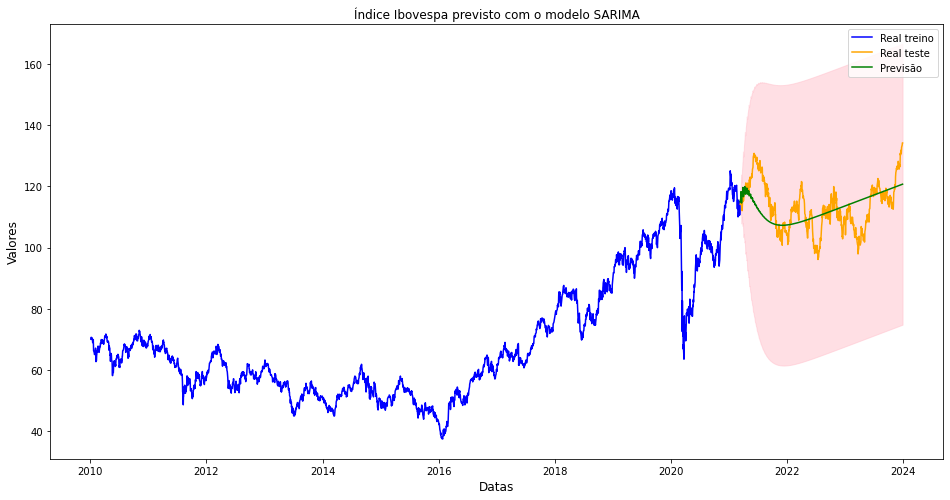

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

# Fazendo previsões
previsoes = melhor_model.get_forecast(steps=len(arima_test))
intervalo_confianca = previsoes.conf_int(alpha=0.05)
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(arima_train.index, arima_train['value'],color='blue', label='Real treino')
plt.plot(arima_test.index, arima_test['value'],color='orange', label='Real teste')

# Linha das previsões
plt.plot(previsoes.predicted_mean.index, previsoes.predicted_mean, color='green', label='Previsão')

# Área do intervalo de confiança
plt.fill_between(intervalo_confianca.index,
                 intervalo_confianca.iloc[:, 0],
                 intervalo_confianca.iloc[:, 1], color='pink', alpha=0.5)

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa previsto com o modelo SARIMA')

plt.legend()
plt.show()

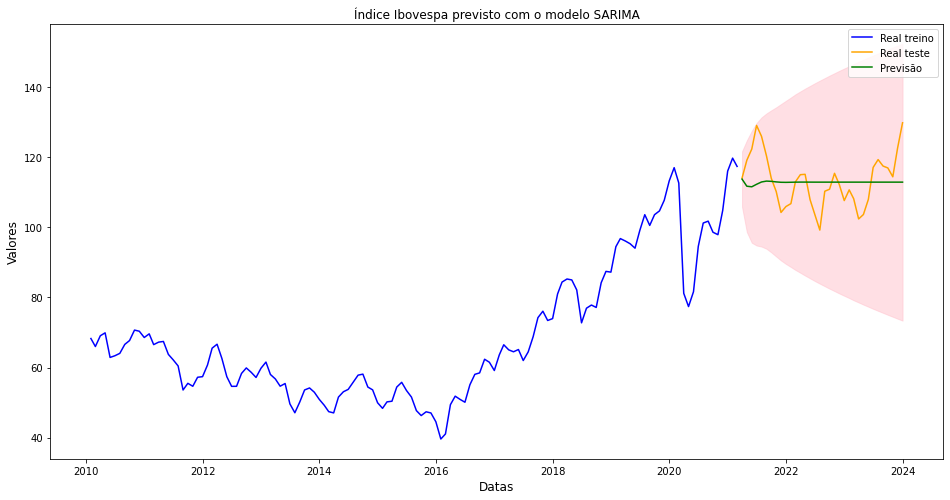

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

# Fazendo previsões
previsoes = melhor_model_arima.get_forecast(steps=len(arima_test))
intervalo_confianca = previsoes.conf_int(alpha=0.05)
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(arima_train.index, arima_train['value'],color='blue', label='Real treino')
plt.plot(arima_test.index, arima_test['value'],color='orange', label='Real teste')

# Linha das previsões
plt.plot(previsoes.predicted_mean.index, previsoes.predicted_mean, color='green', label='Previsão')

# Área do intervalo de confiança
plt.fill_between(intervalo_confianca.index,
                 intervalo_confianca.iloc[:, 0],
                 intervalo_confianca.iloc[:, 1], color='pink', alpha=0.5)

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa previsto com o modelo SARIMA')

plt.legend()
plt.show()

In [265]:
intervalo_confianca

,lower value,upper value
2021-03-12,112.609907,117.322038
2021-03-13,111.640759,118.257909
2021-03-14,111.746733,119.794398
2021-03-15,110.797453,120.025442
2021-03-16,111.340337,121.586106
...,...,...
2023-12-24,74.758106,166.504056
2023-12-25,74.777784,166.523733
2023-12-26,74.797461,166.543411
2023-12-27,74.817138,166.563088


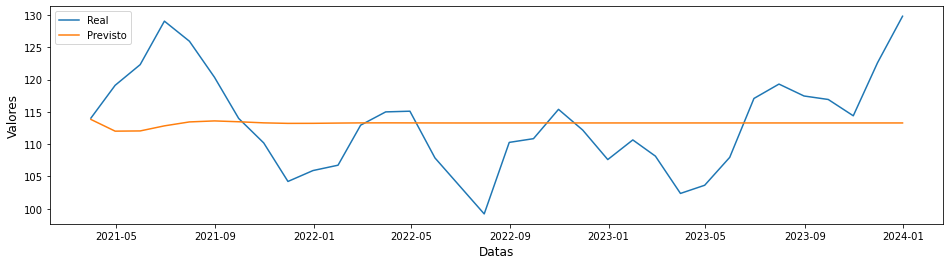

In [154]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(arima_test, label="Real")
plt.plot(melhor_predicao, label="Previsto")
plt.title('', fontsize=20)
plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.legend()

# Prophet

## carregando dados

In [164]:
df = ler_csv('dados/ibovespa.csv')
df_prophet = df_tratamento_dados(df)


## Adequando o df

In [166]:
df_prophet['ds'] = df_prophet.index.copy()
df_prophet.rename(columns={'value': 'y'}, inplace=True)
df_prophet.reset_index(inplace=True, drop=True)
df_prophet.dropna(inplace=True)
df_prophet.tail(9)
len(df_prophet)

5107

## Separando treino e teste

In [167]:
prophet_train, prophet_test = split(df_prophet, 0.8) 

4085
1022


## Ajustando o modelo

In [171]:
# This function fits the prophet model to the input data and generates a forecast
from prophet import Prophet
def fit_and_forecast(df, periods, interval_width, changepoint_range=1):
    # set the uncertainty interval
    Prophet(interval_width=interval_width)
    # Instantiate the model
    model = Prophet(changepoint_range=changepoint_range)
    # Fit the model
    model.fit(df)
    # Create a dataframe with a given number of dates
    future_df = model.make_future_dataframe(periods=periods,freq='D')
    # Generate a forecast for the given dates
    forecast_df = model.predict(future_df)
    #print(forecast_df.head())
    return forecast_df, model, future_df
# Forecast for 365 days with full data
forecast_df, model, future_df = fit_and_forecast(prophet_train, len(prophet_test), 0.95)
print(forecast_df.columns)
forecast_df[['yhat_lower', 'yhat_upper', 'yhat']].head(5)

17:32:17 - cmdstanpy - INFO - Chain [1] start processing
17:32:20 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,yhat_lower,yhat_upper,yhat
0,62.393706,73.837855,68.087461
1,62.601424,74.181731,68.325620
2,62.876480,73.408950,68.469891
3,63.281429,73.883982,68.571497
4,63.131494,74.237218,68.639905


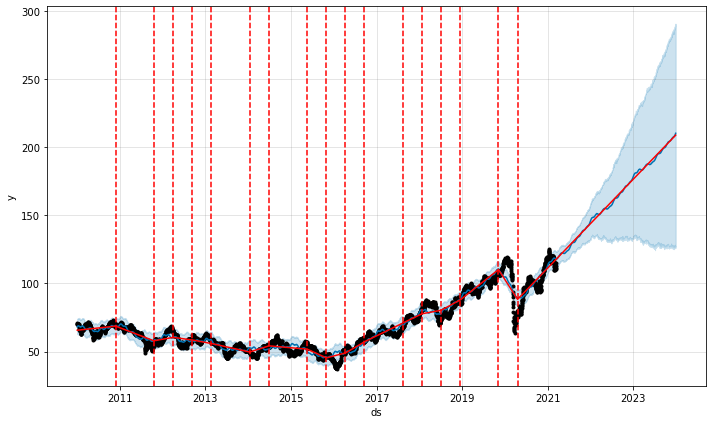

In [59]:
from prophet.plot import add_changepoints_to_plot
axislist = add_changepoints_to_plot(model.plot(forecast_df).gca(), model, forecast_df)

In [620]:
predicao = forecast_df[['ds','yhat']]
predicao = predicao[len(prophet_train):]

In [621]:
prophet_test

,y,ds
4596,106.472000,2022-08-05
4597,107.115333,2022-08-06
4598,107.758667,2022-08-07
4599,108.402000,2022-08-08
4600,108.651000,2022-08-09
...,...,...
5102,133.143000,2023-12-24
5103,133.338000,2023-12-25
5104,133.533000,2023-12-26
5105,134.194000,2023-12-27


## Ajuste de hiperparâmetros

In [25]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['additive','multiplicative']),
               'changepoint_prior_scale':[0.01,0.04, 0.08],
              'holidays_prior_scale': [1,10,20],
               'changepoint_range':[0.4,0.6,0.8],
              'n_changepoints' : [50,75,90,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 216


In [173]:
import holidays

# Cria um DataFrame vazio para armazenar os feriados
holiday = pd.DataFrame([])

# Itera sobre os feriados do Brasil entre 2010 e 2023
for date, name in sorted(holidays.Brazil(years=range(2010, 2024)).items()):
    # Adiciona os feriados ao DataFrame
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)

# Converte a coluna 'ds' para o formato datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Exibe os primeiros registros do DataFrame
print(holiday.head())

          ds                     holiday
0 2010-01-01  Confraternização Universal
1 2010-04-02           Sexta-feira Santa
2 2010-04-21                  Tiradentes
3 2010-05-01          Dia do Trabalhador
4 2010-09-07     Independência do Brasil


In [239]:
import random
import numpy as np
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(prophet_train)
    train_forecast = train_model.make_future_dataframe(periods=len(prophet_test), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = prophet_test
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

{'changepoint_prior_scale': 0.035, 'changepoint_range': 0.85, 'holidays_prior_scale': 15, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


23:11:39 - cmdstanpy - INFO - Chain [1] start processing
23:11:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.408763488647157
total:  4.0
{'changepoint_prior_scale': 0.035, 'changepoint_range': 0.85, 'holidays_prior_scale': 15, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:44 - cmdstanpy - INFO - Chain [1] start processing
23:11:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.40907798026911
total:  8.0
{'changepoint_prior_scale': 0.035, 'changepoint_range': 0.85, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:48 - cmdstanpy - INFO - Chain [1] start processing
23:11:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.407933627942173
total:  12.0
{'changepoint_prior_scale': 0.035, 'changepoint_range': 0.85, 'holidays_prior_scale': 15, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:55 - cmdstanpy - INFO - Chain [1] start processing
23:12:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.41257663841433
total:  17.0
{'changepoint_prior_scale': 0.035, 'changepoint_range': 0.85, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:01 - cmdstanpy - INFO - Chain [1] start processing
23:12:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.410262523990069
total:  21.0
{'changepoint_prior_scale': 0.035, 'changepoint_range': 0.85, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:07 - cmdstanpy - INFO - Chain [1] start processing
23:12:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.40794086169973
total:  25.0
{'changepoint_prior_scale': 0.035, 'changepoint_range': 0.85, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:11 - cmdstanpy - INFO - Chain [1] start processing
23:12:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.41400612145023
total:  28.999999999999996
{'changepoint_prior_scale': 0.035, 'changepoint_range': 0.85, 'holidays_prior_scale': 20, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:22 - cmdstanpy - INFO - Chain [1] start processing
23:12:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.41267177607962
total:  33.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.85, 'holidays_prior_scale': 15, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:30 - cmdstanpy - INFO - Chain [1] start processing
23:12:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.44133399145469
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.85, 'holidays_prior_scale': 15, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:34 - cmdstanpy - INFO - Chain [1] start processing
23:12:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.437932927011934
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.85, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:39 - cmdstanpy - INFO - Chain [1] start processing
23:12:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.438168220414287
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.85, 'holidays_prior_scale': 15, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:45 - cmdstanpy - INFO - Chain [1] start processing
23:12:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.427312824539657
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.85, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:51 - cmdstanpy - INFO - Chain [1] start processing
23:12:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.461632029458485
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.85, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:12:56 - cmdstanpy - INFO - Chain [1] start processing
23:13:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.42435742874232
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.85, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:08 - cmdstanpy - INFO - Chain [1] start processing
23:13:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.430394465931995
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.85, 'holidays_prior_scale': 20, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:14 - cmdstanpy - INFO - Chain [1] start processing
23:13:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.43119624505022
total:  67.0
{'changepoint_prior_scale': 0.06, 'changepoint_range': 0.85, 'holidays_prior_scale': 15, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:20 - cmdstanpy - INFO - Chain [1] start processing
23:13:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.680702690363937
total:  71.0
{'changepoint_prior_scale': 0.06, 'changepoint_range': 0.85, 'holidays_prior_scale': 15, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:26 - cmdstanpy - INFO - Chain [1] start processing
23:13:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.63161450442205
total:  75.0
{'changepoint_prior_scale': 0.06, 'changepoint_range': 0.85, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:32 - cmdstanpy - INFO - Chain [1] start processing
23:13:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.687429660843534
total:  79.0
{'changepoint_prior_scale': 0.06, 'changepoint_range': 0.85, 'holidays_prior_scale': 15, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:48 - cmdstanpy - INFO - Chain [1] start processing
23:13:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.693239332192523
total:  83.0
{'changepoint_prior_scale': 0.06, 'changepoint_range': 0.85, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:13:59 - cmdstanpy - INFO - Chain [1] start processing
23:14:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.71324473173002
total:  88.0
{'changepoint_prior_scale': 0.06, 'changepoint_range': 0.85, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:04 - cmdstanpy - INFO - Chain [1] start processing
23:14:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.672938806048359
total:  92.0
{'changepoint_prior_scale': 0.06, 'changepoint_range': 0.85, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:17 - cmdstanpy - INFO - Chain [1] start processing
23:14:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.70598775123293
total:  96.0
{'changepoint_prior_scale': 0.06, 'changepoint_range': 0.85, 'holidays_prior_scale': 20, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:14:25 - cmdstanpy - INFO - Chain [1] start processing
23:14:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 9.640865004952884
total:  100.0


C:\Users\alex\AppData\Local\Temp\ipykernel_21164\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


In [240]:
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,RMSE,Parameters,MAE,MAPE
0,9.407934,"{'changepoint_prior_scale': 0.035, 'changepoin...",7.310122,0.063779
1,9.407941,"{'changepoint_prior_scale': 0.035, 'changepoin...",7.312304,0.063826
2,9.408763,"{'changepoint_prior_scale': 0.035, 'changepoin...",7.304838,0.063660
3,9.409078,"{'changepoint_prior_scale': 0.035, 'changepoin...",7.319117,0.063928
4,9.410263,"{'changepoint_prior_scale': 0.035, 'changepoin...",7.305390,0.063656


In [243]:
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

RMSE: 9.407933627942173
MAE: 7.310121988031134
MAPE: 0.0637787701069828
{'changepoint_prior_scale': 0.035, 'changepoint_range': 0.85, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


0.035


In [207]:
train_model =Prophet(changepoint_prior_scale = parameters.loc[0, 'Parameters']['changepoint_prior_scale'],
                     holidays_prior_scale = parameters.loc[0, 'Parameters']['holidays_prior_scale'],
                     n_changepoints = parameters.loc[0, 'Parameters']['n_changepoints'],
                     changepoint_range=parameters.loc[0, 'Parameters']['changepoint_range'],
                     seasonality_mode = parameters.loc[0, 'Parameters']['seasonality_mode'],
                     yearly_seasonality = True,
                     holidays=holiday, 
                     interval_width=0.95)
train_model.fit(prophet_train)
train_forecast = train_model.make_future_dataframe(periods=len(prophet_test), freq='D',include_history = False)
train_forecast = train_model.predict(train_forecast)
predicao=train_forecast[['ds','yhat']]
Actual = prophet_test
RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
RMSE

19:35:24 - cmdstanpy - INFO - Chain [1] start processing
19:35:27 - cmdstanpy - INFO - Chain [1] done processing


9.415453459462714

In [1]:
from prophet.plot import add_changepoints_to_plot
axislist = add_changepoints_to_plot(model.plot(train_forecast).gca(), model, train_forecast)

NameError: name 'model' is not defined

In [279]:
best_prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Confraternização Universal,Confraternização Universal_lower,Confraternização Universal_upper,Dia do Trabalhador,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-03-12,108.135347,94.990173,116.788979,108.135347,108.135347,0.0,0.0,0.0,0.0,...,-0.005480,-0.005480,-0.005480,0.091679,0.091679,0.091679,0.0,0.0,0.0,106.112418
1,2021-03-13,108.146989,95.865653,116.712767,108.146830,108.146989,0.0,0.0,0.0,0.0,...,-0.021747,-0.021747,-0.021747,-0.083161,-0.083161,-0.083161,0.0,0.0,0.0,105.932952
2,2021-03-14,108.158630,95.235586,116.929572,108.157874,108.159180,0.0,0.0,0.0,0.0,...,-0.044598,-0.044598,-0.044598,-0.247389,-0.247389,-0.247389,0.0,0.0,0.0,105.757515
3,2021-03-15,108.170272,94.535745,116.851440,108.168214,108.172280,0.0,0.0,0.0,0.0,...,-0.068015,-0.068015,-0.068015,-0.399922,-0.399922,-0.399922,0.0,0.0,0.0,105.593206
4,2021-03-16,108.181914,94.401073,116.488262,108.178072,108.185525,0.0,0.0,0.0,0.0,...,0.035360,0.035360,0.035360,-0.539889,-0.539889,-0.539889,0.0,0.0,0.0,105.568257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,2023-12-24,119.974965,99.103282,140.231736,102.432605,136.895164,0.0,0.0,0.0,0.0,...,-0.044598,-0.044598,-0.044598,1.563924,1.563924,1.563924,0.0,0.0,0.0,119.385163
1018,2023-12-25,119.986607,99.801612,140.624294,102.422174,136.921776,0.0,0.0,0.0,0.0,...,-0.068015,-0.068015,-0.068015,1.671202,1.671202,1.671202,0.0,0.0,0.0,119.722102
1019,2023-12-26,119.998249,98.784196,140.041611,102.411544,136.948389,0.0,0.0,0.0,0.0,...,0.035360,0.035360,0.035360,1.788366,1.788366,1.788366,0.0,0.0,0.0,119.712846
1020,2023-12-27,120.009890,100.246839,141.010130,102.400931,136.975001,0.0,0.0,0.0,0.0,...,0.054757,0.054757,0.054757,1.914216,1.914216,1.914216,0.0,0.0,0.0,119.869734


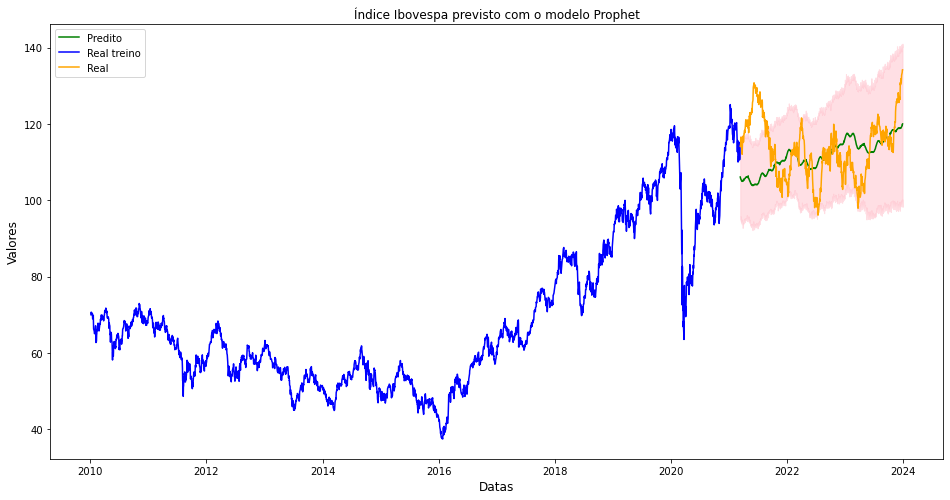

In [288]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
# Plotando o primeiro gráfico
plt.plot(best_prediction['ds'], best_prediction['yhat'],color='green', label='Predito')
# Plotando o segundo gráfico
# Linha da série temporal
plt.plot(prophet_train['ds'], prophet_train['y'],color='blue', label='Real treino')
plt.plot(prophet_test['ds'], prophet_test['y'],color='orange', label='Real')

# Área do intervalo de confiança
plt.fill_between(best_prediction['ds'],
                 best_prediction['yhat_upper'],
                 best_prediction['yhat_lower'], color='pink', alpha=0.5)

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

In [ ]:
from prophet.plot import add_changepoints_to_plot
axislist = add_changepoints_to_plot(model.plot(forecast_df).gca(), model, forecast_df)

In [210]:
predicao

,ds,yhat
0,2021-03-12,106.207268
1,2021-03-13,106.028733
2,2021-03-14,105.854226
3,2021-03-15,105.690820
4,2021-03-16,105.666750
...,...,...
1017,2023-12-24,119.933600
1018,2023-12-25,120.270809
1019,2023-12-26,120.261262
1020,2023-12-27,120.418179


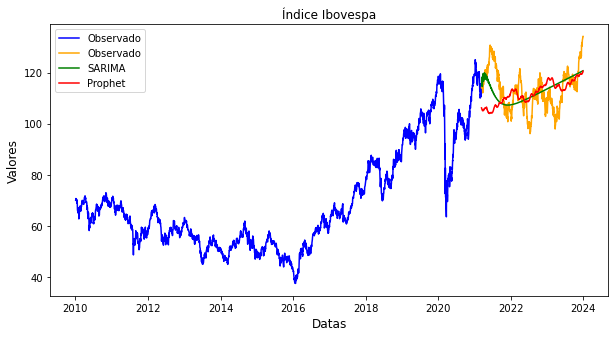

In [237]:
# Plotando os resultados
plt.figure(figsize=(10, 5))

plt.plot(prophet_train['ds'], prophet_train['y'], color='blue', label='Observado')
# Linha da série temporal
plt.plot(prophet_test['ds'], prophet_test['y'], color='orange', label='Observado')

# Linha das previsões
plt.plot(predicao_arima['ds'], predicao_arima['y'], color='green', label='SARIMA')

plt.plot(train_forecast['ds'], train_forecast['yhat'], color='red', label='Prophet')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa')
plt.legend()
plt.show()

In [867]:
arima_test

,value
data,
2022-08-05,106.472000
2022-08-06,107.115333
2022-08-07,107.758667
2022-08-08,108.402000
2022-08-09,108.651000
...,...
2023-12-24,133.143000
2023-12-25,133.338000
2023-12-26,133.533000
